In [1]:
import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb as hsv2rgb
import numpy as np
import math

from config_reader import config_reader
from model import get_testing_model
import util

/home/streamax/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''
                                    Get testing model and load the best weights

# stages = 6
# branch 1 (PAF) 
        2 times the num of limbs
        40 = 2 * 20 = 2 * (5 fingers * 4 connections per finger)
# branch 2 (Heatmap)
        num of joints + 1
        22 = 21 keypoints + background

the h5 file is the weight I got after training
''' 

np_branch1 = 40
np_branch2 = 22

model = get_testing_model(np_branch1,np_branch2)
weights_path = "/home/streamax/keras-handpose/training/Canonical/weights.0050.h5"
model.load_weights(weights_path)

oriImage size: (131, 132, 3)


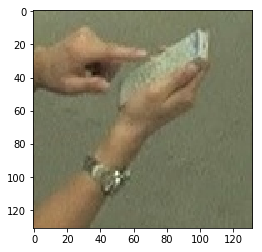

In [3]:
"""
This model failed on the random picture I took :(

"""

test_image = '/home/streamax/hand143_panopticdb/img_crop/00000166.jpg'
# we have also tested 00000009.jpg

# test_image = '/home/streamax/Desktop/my_hand.jpg'
oriImg = cv2.imread(test_image) # B,G,R order

# resize x and y by the same scale, don't be different
# oriImg = cv2.resize(oriImg, (0,0), fx = 0.3, fy = 0.3, interpolation=cv2.INTER_CUBIC)

print('oriImage size:',oriImg.shape)
plt.imshow(oriImg[:,:,[2,1,0]])

param, model_params = config_reader()
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
# modify the config file, to set different scales on which to shrink or magnify the oriImg
# boxsize is 368, how many times is it to boxsize

scale  0.8
Input shape: (1, 296, 304, 3)
Output shape (heatmap): (1, 37, 38, 22)


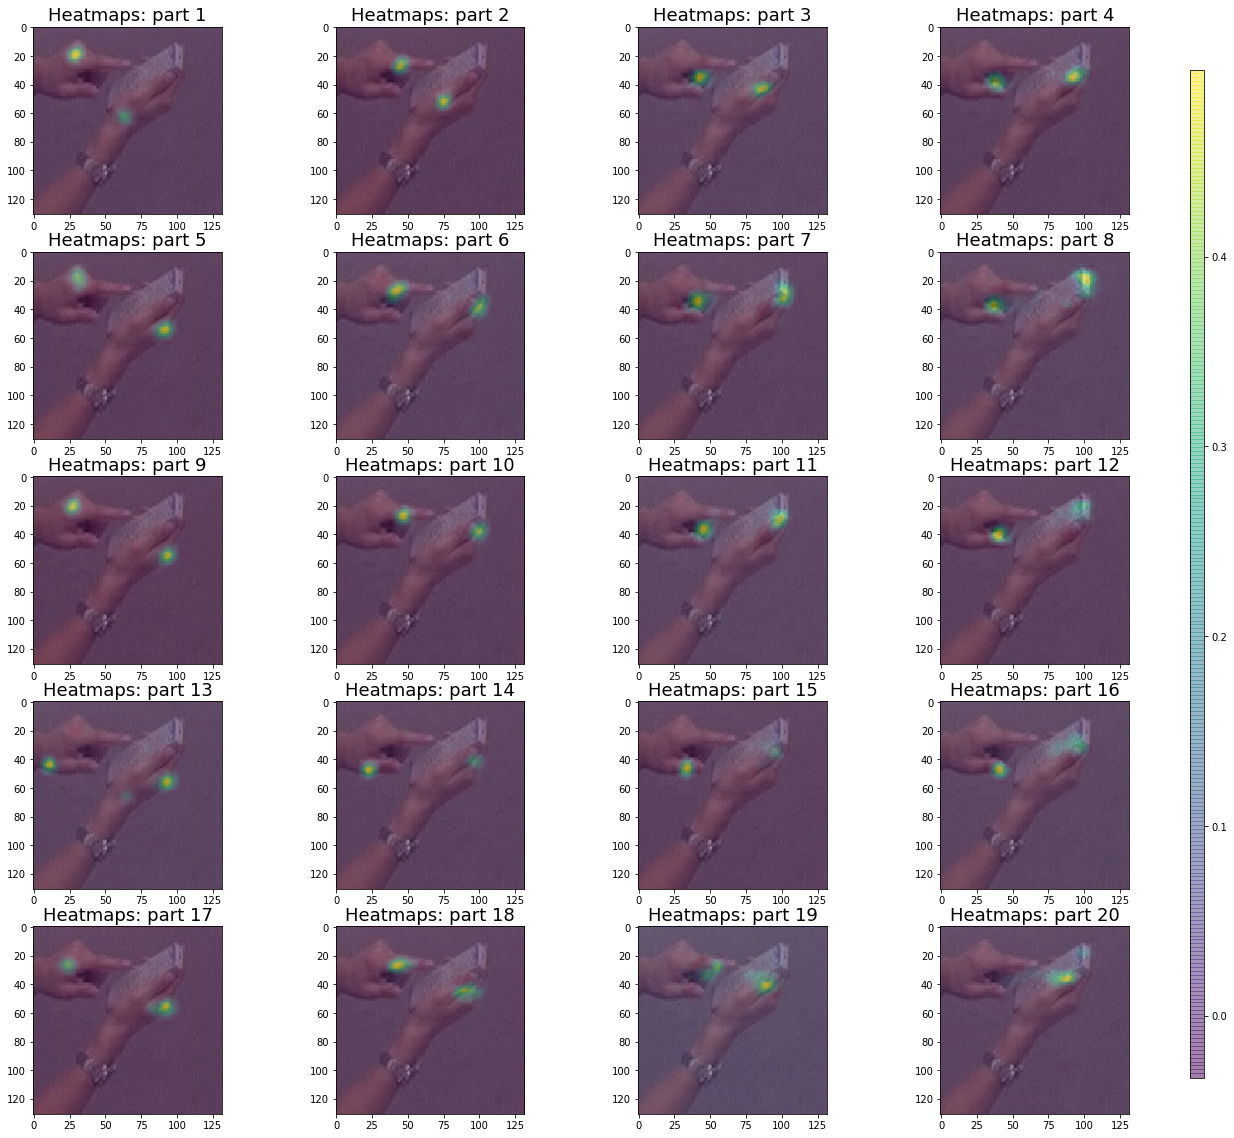

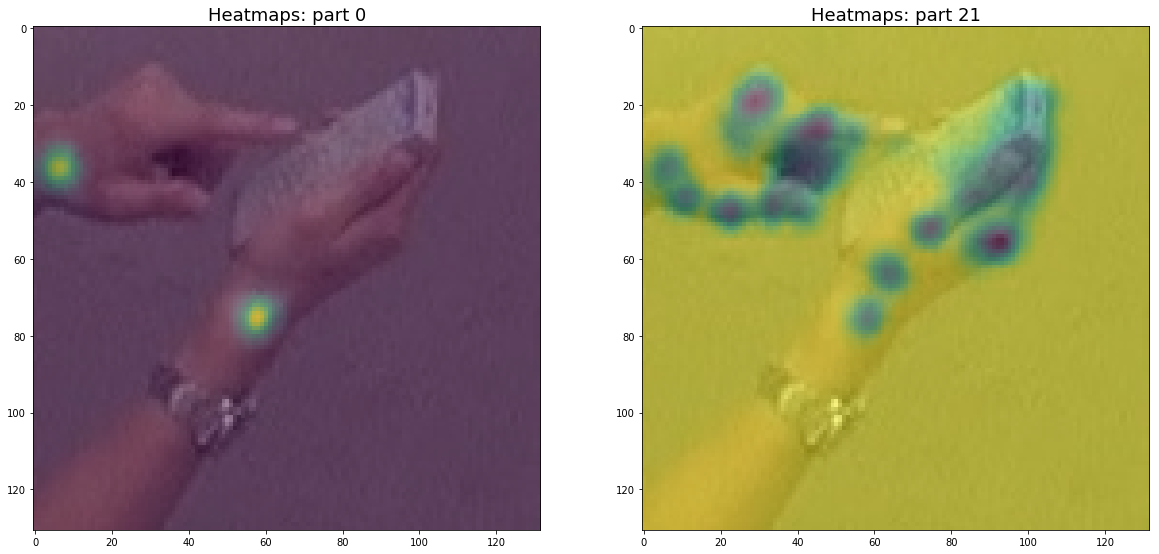

In [4]:
""" SHOW HEATMAPS
step 2: use the bset scale (0.8) to get the heatmaps of all keypoints

according to the config file, the scale_level 5 corresponds to scale 0.8

"""

# figure shows heatmaps
f, axarr = plt.subplots(5, 4)
f.set_size_inches((20, 20))

f2, axarr2 = plt.subplots(1, 2)
f2.set_size_inches((20, 20))

# only at one scale
scale_level = 5
scale = multiplier[scale_level]
print("scale ",param['scale_search'][scale_level])

imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])
input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2))
# required shape (1, width, height, channels)  
print("Input shape: " + str(input_img.shape))
output_blobs = model.predict(input_img)
print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
# extract outputs, resize, and remove padding
heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

# visualization
# part
for part_id in range(20):
    m = part_id // 4
    n = part_id % 4
    axarr[m][n].imshow(oriImg[:,:,[2,1,0]])
    ax = axarr[m][n].imshow(heatmap[:,:,part_id+1], alpha=.5)
    axarr[m][n].set_title('Heatmaps: part %d' %(part_id + 1),fontsize=18)

for n,part_id in enumerate([0,21]):
    axarr2[n].imshow(oriImg[:,:,[2,1,0]])
    ax2 = axarr2[n].imshow(heatmap[:,:,part_id], alpha=.5)
    axarr2[n].set_title('Heatmaps: part %d' %(part_id),fontsize=18)

f.subplots_adjust(right=0.93)
cbar_ax = f.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f.colorbar(ax, cax=cbar_ax)

scales: ['0.7', '0.8', '0.9']
multipliers: [1.9664122137404578, 2.2473282442748093, 2.5282442748091603]
Input shape: (1, 296, 304, 3)
Output shape (paf): (1, 37, 38, 40)


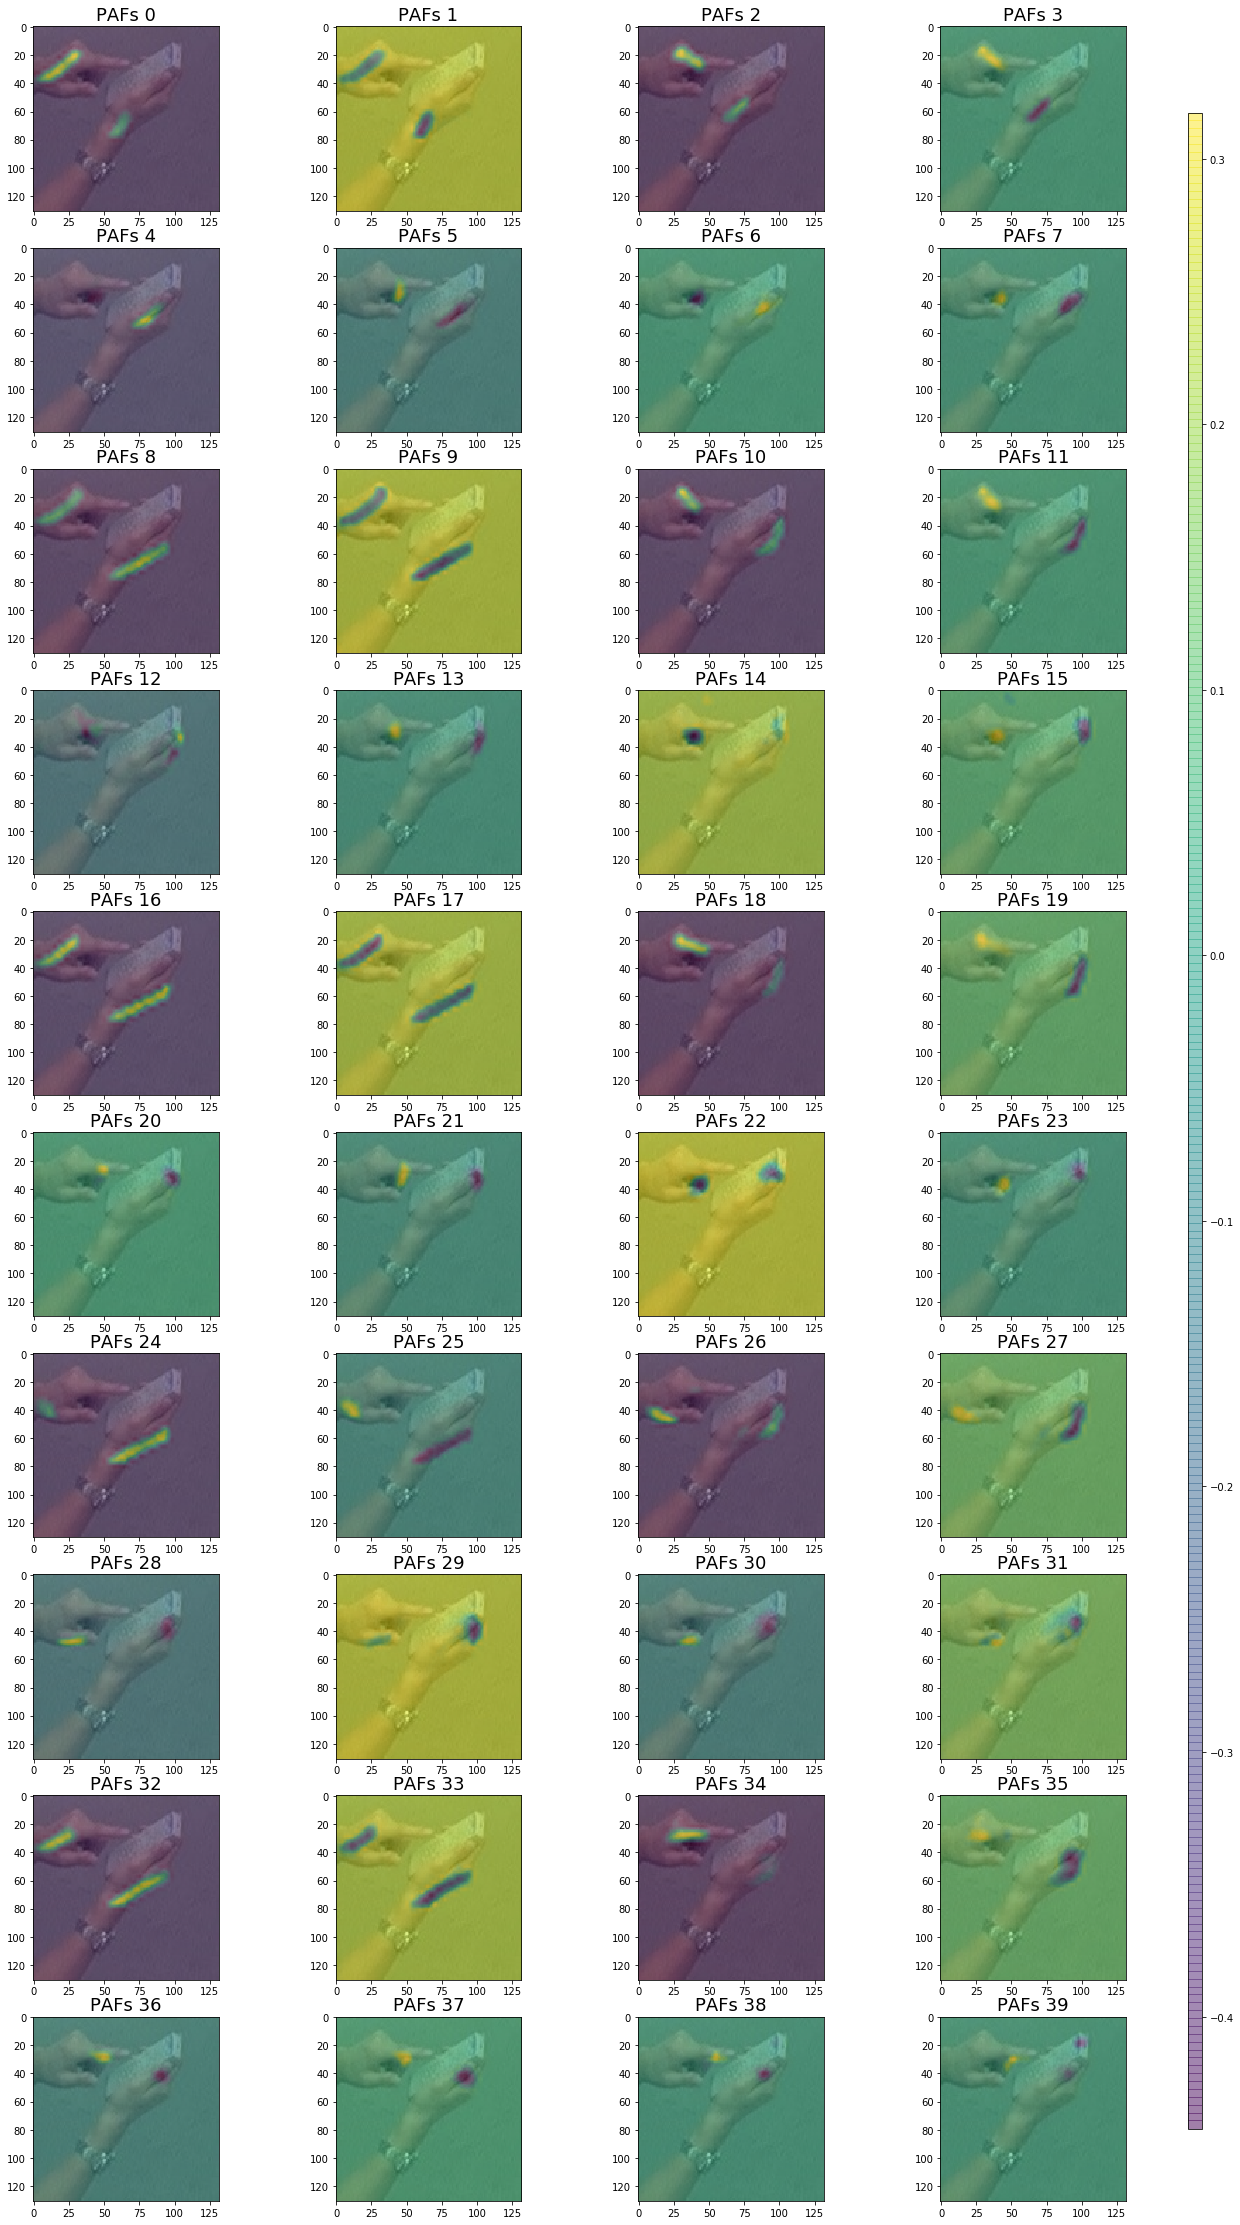

In [5]:
"""SHOW PAFS
The scales is 0.8

only pafs here

"""

mul4avg = [float(x) * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_for_avg']]
print("scales:", param['scale_for_avg'])
print("multipliers:", mul4avg)
scale = mul4avg[1]

# third figure shows PAFs
f3, axarr3 = plt.subplots(10, 4)
f3.set_size_inches((20, 40))

imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])
input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) 
# required shape (1, width, height, channels) 
print("Input shape: " + str(input_img.shape))  

output_blobs = model.predict(input_img)
print("Output shape (paf): " + str(output_blobs[0].shape))
    
paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

for paf_id in range(40):
    
    m = paf_id // 4
    n = paf_id % 4

    # limb pair
#     limb_from, limb_to = 6,7
    axarr3[m][n].imshow(oriImg[:,:,[2,1,0]])
    ax3 = axarr3[m][n].imshow(paf[:,:,paf_id], alpha=.5)
    axarr3[m][n].set_title('PAFs %d' %paf_id, fontsize=18)
    
#     axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
#     ax3x = axarr3.flat[m].imshow(paf[:,:,limb_from], alpha=.5)
#     axarr3.flat[m].set_title('PAFs (x comp. of %d to %d): scale %d' %(limb_from,limb_to,m), fontsize=18)
#     axarr3.flat[len(mul4avg) + m].imshow(oriImg[:,:,[2,1,0]])
#     ax3y = axarr3.flat[len(mul4avg) + m].imshow(paf[:,:,limb_to], alpha=.5) # right wrist
#     axarr3.flat[len(mul4avg) + m].set_title('PAFs (y comp. of %d to %d): scale %d' %(limb_to,limb_from,m),fontsize=18)

f3.subplots_adjust(right=0.93)
cbar_ax = f3.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f3.colorbar(ax3, cax=cbar_ax)

# f3.subplots_adjust(right=0.93)
# cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
# _ = f3.colorbar(ax3x, cax=cbar_axx)
# cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
# _ = f3.colorbar(ax3y, cax=cbar_axy)

### 2.1 Simultaneous Detection and Association

scales: ['0.7', '0.8', '0.9']
Input shape: (1, 264, 264, 3)
Output shape (heatmap): (1, 33, 33, 22)
Input shape: (1, 296, 304, 3)
Output shape (heatmap): (1, 37, 38, 22)
Input shape: (1, 336, 336, 3)
Output shape (heatmap): (1, 42, 42, 22)


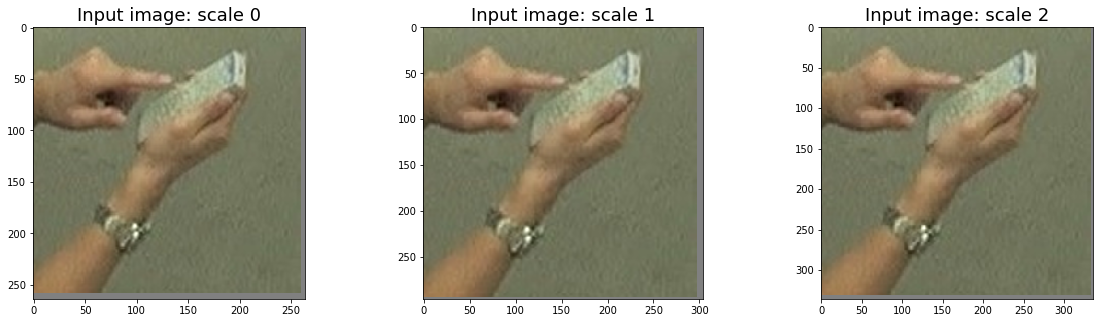

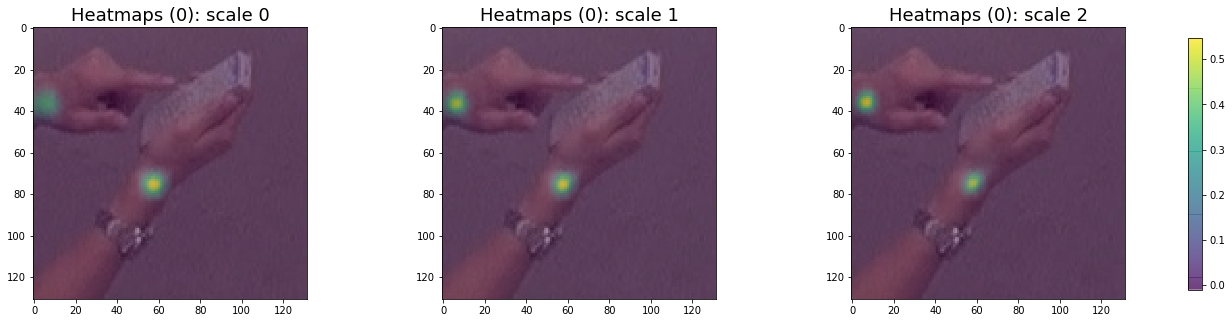

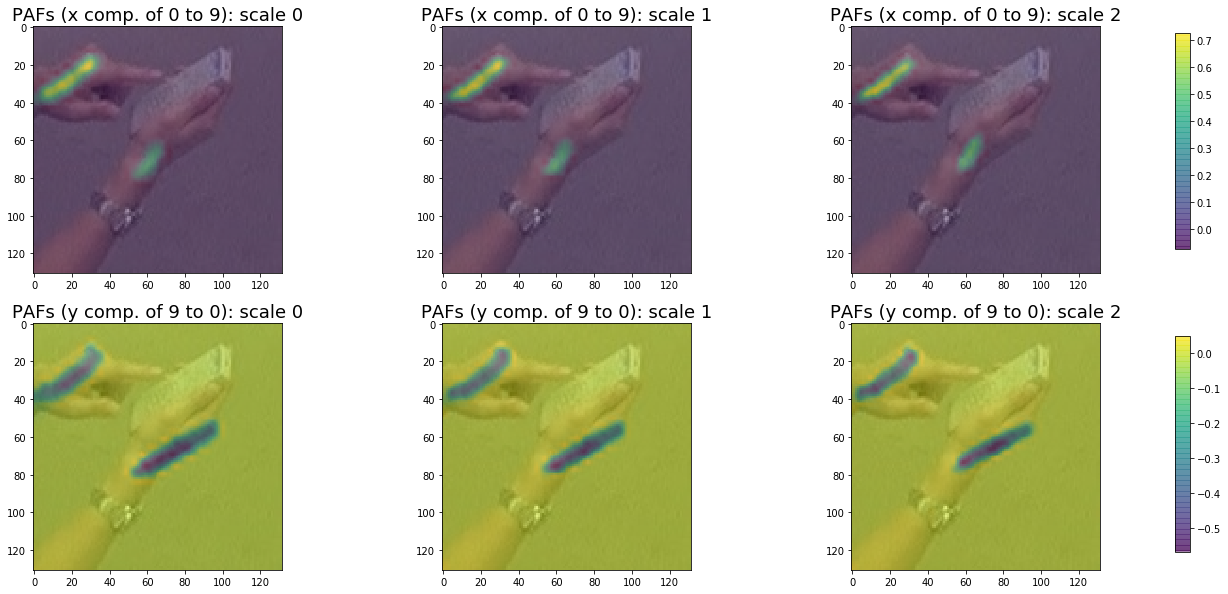

In [6]:
"""
This step averages the predictions over 3 scales [0.7, 0.8, 0.9]

and has heatmap_avg and pafs_avg

"""

mul4avg = [float(x) * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_for_avg']]
print("scales:", param['scale_for_avg'])

heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], np_branch2))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], np_branch1))
# first figure shows padded images
f, axarr = plt.subplots(1, len(mul4avg))
f.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(mul4avg))
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(mul4avg))
f3.set_size_inches((20, 10))

for m in range(len(mul4avg)):
    scale = mul4avg[m]
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
    axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
    axarr[m].set_title('Input image: scale %d' % m,fontsize=18)

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
    print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # visualization
    # part
    part_id = 0
    
    axarr2[m].imshow(oriImg[:,:,[2,1,0]])
    ax2 = axarr2[m].imshow(heatmap[:,:,part_id], alpha=.5)
    axarr2[m].set_title('Heatmaps (%d): scale %d' %(part_id, m),fontsize=18)
    
    # limb
    limb_from, limb_to = 0,9
    
    axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
    ax3x = axarr3.flat[m].imshow(paf[:,:,limb_from], alpha=.5)
    axarr3.flat[m].set_title('PAFs (x comp. of %d to %d): scale %d' %(limb_from,limb_to,m),fontsize=18)
    axarr3.flat[len(mul4avg) + m].imshow(oriImg[:,:,[2,1,0]])
    ax3y = axarr3.flat[len(mul4avg) + m].imshow(paf[:,:,limb_to], alpha=.5) # right wrist
    axarr3.flat[len(mul4avg) + m].set_title('PAFs (y comp. of %d to %d): scale %d' %(limb_to,limb_from,m),fontsize=18)
    
    heatmap_avg = heatmap_avg + heatmap / len(mul4avg)
    paf_avg = paf_avg + paf / len(mul4avg)

f2.subplots_adjust(right=0.93)
cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f2.colorbar(ax2, cax=cbar_ax)

f3.subplots_adjust(right=0.93)
cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
_ = f3.colorbar(ax3x, cax=cbar_axx)
cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
_ = f3.colorbar(ax3y, cax=cbar_axy)

Heatmap for right knee. Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

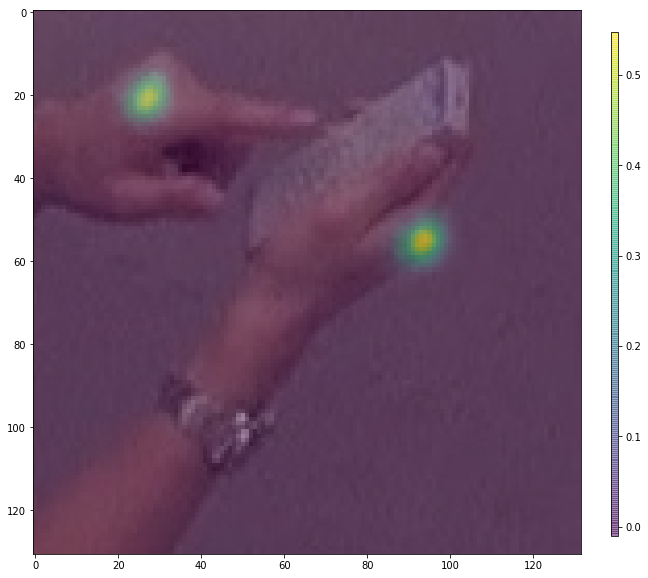

In [7]:
"""
Here we show a part in a big figure
"""

plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,9], alpha=.5)
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(10, 10)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
_ = fig.colorbar(ax2, cax=cbar_ax)

paf vectors for right elbow and right wrist

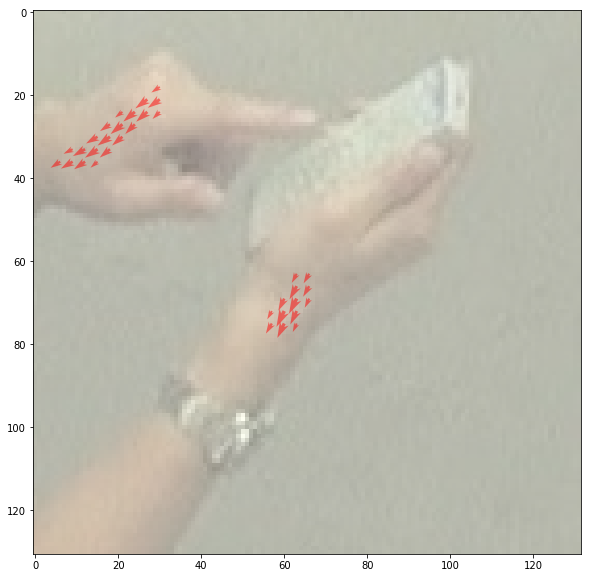

In [8]:
from numpy import ma

U = paf_avg[:,:,0] * -1
V = paf_avg[:,:,1]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 3
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=30, headaxislength=4, alpha=.5, width=0.01, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

### 2.2 Confidence Maps for Part Detection

In [9]:
"""
get all_peaks from heatmaps
"""

from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

# we have 21 parts
for part in range(21):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

<Figure size 432x288 with 0 Axes>

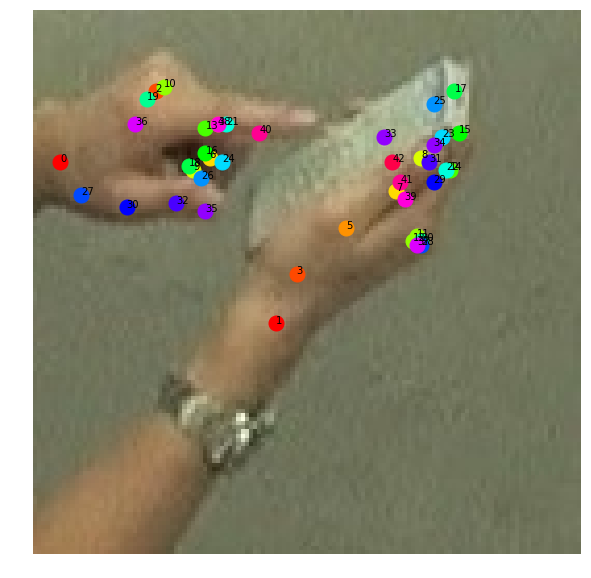

In [10]:
"""
Once we got the all_peaks, we can plot the prediction on the image

method1: use matplotlib
"""

plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(oriImg[:,:,[2,1,0]])
plt.axis('off')

for i,pts in enumerate(all_peaks):
    rgb = hsv2rgb([i/float(len(all_peaks)),1.0,1.0])
    for p in pts:
        plt.plot(p[0],p[1],color=rgb,marker='o',ms=15)
        plt.text(p[0], p[1], '{0}'.format(p[3]),fontsize=10)

```
"""
method2: use OpenCV
"""

cmap = matplotlib.cm.get_cmap('hsv')
canvas = cv2.imread(test_image) # B,G,R order

for i in range(21):
    rgba = np.array(cmap(1 - i/21. - 1./42))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 3, color=rgba, thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

```

(-0.5, 131.5, 130.5, -0.5)

<Figure size 432x288 with 0 Axes>

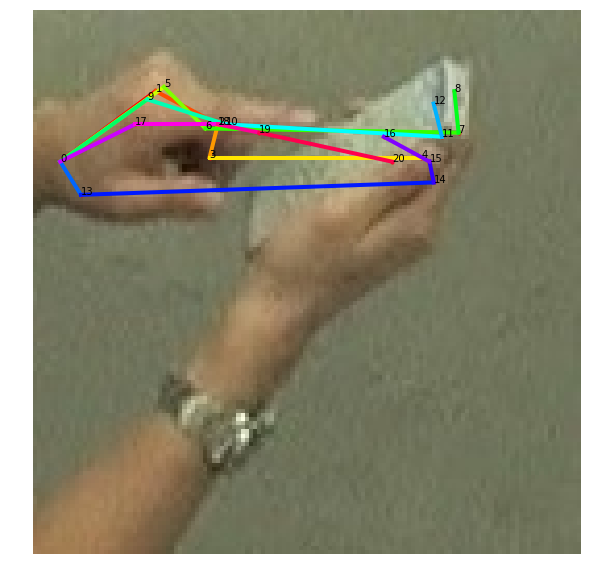

In [11]:
""" NOTE: this ONLY applies to a single image

once we've got 21 keypoints in all_peaks, we can draw them out and connect them

The line in matplotlib is drawn this way:
# draw vertical line from (70,100) to (70, 250)
plt.plot([70, 70], [100, 250], 'k-', lw=2)
"""

pts = all_peaks
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(oriImg[:,:,[2,1,0]])

edges = [[0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],
         [0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20]]

for p in range(len(pts)):
    plt.plot(pts[p][0][0], pts[p][0][1],'r.')
    plt.text(pts[p][0][0], pts[p][0][1], '{0}'.format(p))
for ie, e in enumerate(edges):
    rgb = matplotlib.colors.hsv_to_rgb([ie/float(len(edges)),1.0,1.0])
    ptx = [pts[e[0]][0][0],pts[e[1]][0][0]]
    pty = [pts[e[0]][0][1],pts[e[1]][0][1]]
    # x position and y position of 2 points
    plt.plot(ptx,pty,color=rgb,lw=4)

plt.axis('off')

```
pipeline: 

          Input image| -> heatmaps -> all_peaks ->| 
                     | ----------> pafs --------->| connection_all -> subset
```

=============================================================

```
Input shape: (1, 296, 304, 3)
Output shape (heatmap): (1, 37, 38, 22)
Output shape (paf): (1, 37, 38, 40)

---
all_peaks:
- each one of the 21 rows contains the candidates of that joint)
- all_peaks[0][0] is (6, 36, 0.5041384845972061, 0) 
which shows the position (6,36) and the score (0.5041384845972061) of the first (0) candidate of joint 0

[[(6, 36, 0.5041384845972061, 0), (58, 75, 0.6196061819791794, 1)],
 [(29, 19, 0.8349406272172928, 2), (63, 63, 0.47033876925706863, 3)],
 [(44, 27, 0.6423706710338593, 4), (75, 52, 0.7782936990261078, 5)],
 [(42, 35, 0.6052334308624268, 6), (87, 43, 0.5967598408460617, 7)],
 [(93, 35, 0.5910119712352753, 8), (38, 38, 0.4706675559282303, 9)],
 [(31, 18, 0.5966003090143204, 10),
  (92, 54, 0.8652918040752411, 11),
  (91, 55, 0.849274218082428, 12)],
  ...
 [(44, 27, 0.41408301889896393, 38), (89, 45, 0.3717571869492531, 39)],
 [(54, 29, 0.2344242613762617, 40), (88, 41, 0.3775034621357918, 41)],
 [(86, 36, 0.3909258246421814, 42)]]
  
---
connection_all:
- each one of the 20 rows contains the possible connections between the joints that can form the limb
- this forms 20 sets of bipartite trees
- connection_all[0][0] is array([1.        , 3.        , 0.77472171, 1.        , 1.        ])
which shows peak (1) and peak (3) form a limb with the score (0.77472171) 

[array([[1.        , 3.        , 0.77472171, 1.        , 1.        ],
        [0.        , 2.        , 0.6589593 , 0.        , 0.        ]]),
 array([[2.        , 4.        , 0.87680815, 0.        , 0.        ],
        [3.        , 5.        , 0.76560406, 1.        , 1.        ]]),
        ...
 array([[39.        , 41.        ,  0.72083119,  1.        ,  1.        ],
        [38.        , 40.        ,  0.53515553,  0.        ,  0.        ]]),
 array([[41.        , 42.        ,  0.21522783,  1.        ,  0.        ]])]

---
subset:
- each row is a set of whole connections of a hand
- subset[0] shows peak (1) is the joint (0) in this hand and peak (3) is the joint (2) and so on

array([[ 1.        ,  3.        ,  5.        ,  7.        ,  8.        ,
        12.        , -1.        , -1.        , -1.        , 20.        ,
        22.        , 23.        , 25.        , 28.        , 29.        ,
        31.        , 33.        , 37.        , 39.        , 41.        ,
        42.        , 20.03499006, 18.        ],
       [ 0.        ,  2.        ,  4.        ,  6.        ,  9.        ,
        10.        , 13.        , 16.        , 18.        , 19.        ,
        21.        , 24.        , 26.        , 27.        , 30.        ,
        32.        , 35.        , 36.        , 38.        , 40.        ,
        -1.        , 23.03265776, 20.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        11.        , 14.        , 15.        , 17.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ,  3.740608  ,  4.        ]])

  ```
  
  

In [12]:
"""
20 limbs, 2 joints per limb
20 pairs of pafs, with x and y directions
"""
limbSeq = [[0,1], [1,2], [2,3], [3,4], [0,5], [5,6], [6,7], [7,8], [0,9], [9,10], [10,11], [11,12],
          [0,13], [13,14], [14,15], [15,16], [0,17], [17,18], [18,19], [19,20]]

pafIdx = [[0,1], [2,3], [4,5], [6,7], [8,9], [10,11], [12,13], [14,15], [16,17], [18,19], [20,21], 
          [22,23], [24,25], [26,27], [28,29], [30,31], [32,33], [34,35], [36,37], [38,39]]

### 2.3 Part Affinity Fields for Part Association

In [13]:
"""
given all_peaks, make a list of connection_all with weights
"""

connection_all = []
special_k = []
mid_num = 10

for k in range(len(pafIdx)):
    score_mid = paf_avg[:,:,[x for x in pafIdx[k]]]
    candA = all_peaks[limbSeq[k][0]]
    candB = all_peaks[limbSeq[k][1]]
    nA,nB = len(candA),len(candB)
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                # Unit vector
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                if norm == 0: continue # no overlaps!
                vec = np.divide(vec, norm)
                
                # Line integral
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                vec_x = np.array([score_mid[int(round(I[1])), int(round(I[0])), 0] for I in startend])
                vec_y = np.array([score_mid[int(round(I[1])), int(round(I[0])), 1] for I in startend])
                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts)
                # the original is this:
                # if oriImg.shape[0] > 18, 
                # score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                
                # use 2 rules to eliminate some bad candidates
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior])

        # sort by weight, put the maximum weight at first
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
#         print('connection_candidate',connection_candidate)
        
        # make sure that no 2 edges share a node, so select the first few matches by score
        connection = np.zeros((0,5))
        for c in connection_candidate:
            i,j,s = c
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break
        connection_all.append(connection)

    # if the candidate doesn't exist
    else:
        special_k.append(k)
        connection_all.append([])

### Multi-Person Parsing using PAFs

In [14]:
"""
get the most likely connection which is a subset of connection_all

the length of subset is len(limbSeq) + 2, with the last 2 numbers as the following:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
"""

subset = -1 * np.ones((0, 23))
candidate = np.array([item for sublist in all_peaks for item in sublist])
# print('candidate:\n', candidate)

for k in range(len(pafIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k])
#         print('partAs',partAs)
#         print('partBs',partBs)
#         print('indexA,indexB',indexA,indexB)
        
        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            
            for j in range(len(subset)):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            # if find no partA in the subset, create a new subset
            if not found and k < 20:
                row = -1 * np.ones(23)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])
            
            # if find 1 match, fill in the next one
            elif found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
    
            # if found 2 and disjoint, merge them
            elif found == 2:
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
# print('subset 1 \n',subset)

# delete some rows of subset which has few parts occur or with very low score
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

# print('subset 2 \n',subset)

<Figure size 432x288 with 0 Axes>

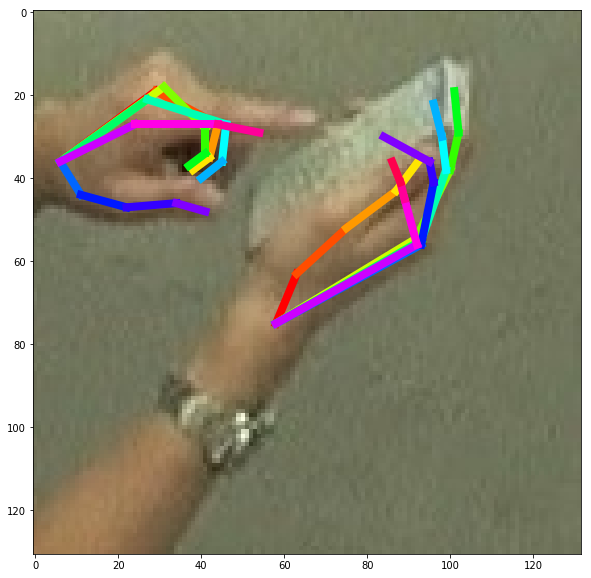

In [15]:
"""
using subset, we can parse multi-hands
left and right hands are mirror-like
"""

plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(oriImg[:,:,[2,1,0]])

for i in range(len(limbSeq)):
    rgb = hsv2rgb([i/float(len(limbSeq)),1.0,1.0])
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])]
        if -1 in index:
            continue
        X = candidate[index.astype(int), 0]
        Y = candidate[index.astype(int), 1]
        plt.plot(X,Y,color=rgb,lw=8)